In [1]:
from DLtools.Data_preprocess import series_to_supervised,load_data,preprocess
from DLtools.evaluation_rec import error_rec,eva_error

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
np.random.seed(42)

In [17]:
def LSTM_model(train_X, train_Y, validation,  n_timelag,n_feature):  
    EPOCH = 100
    BATCH = 7
    
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_timelag, n_feature)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=2)
    callbacks = [callback_early_stopping]
    history = model.fit(train_X, train_Y, epochs=EPOCH, batch_size=BATCH, verbose=1,shuffle=False,validation_data=validation,callbacks=callbacks)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model


In [4]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean()
col_r = rw.rain_df.columns
col_w = rw.water_df.columns

X_in = df['2013-01-01':'2015-01-01'].interpolate(limit=15)
X_in = X_in.astype('float32')

DataFrame shape: (465169, 35)


In [5]:
TARGET = 'CPY015_w'

from sklearn.preprocessing import MinMaxScaler
scaler_target = MinMaxScaler()
scaler_target.fit(X_in[TARGET].values.reshape(-1,1))

MinMaxScaler()

In [15]:
col = ['model',"n_feature","n_timelag",'MSE_train',"MSE_test",'NSE_trian', "NSE_test",]
Rec = pd.DataFrame(columns =col)

TARGET = 'CPY015_w'
FEATURE = X_in.shape[1]
TIME = 7
prep = preprocess(X_in,Y_column=TARGET,n_timelag=TIME,n_feature=FEATURE,scale_ornot=True)
train_X, train_Y = prep.train_X,prep.train_Y
val_X,val_y = prep.val_X,prep.val_y
test_X,test_y =prep.test_X,prep.test_Y
ori_X,ori_Y = prep.train_val_X,prep.train_val_Y

VALIDATION = (val_X,val_y) 




================================================== preview Supervised ==================================================
            CHM002_r(t-7)  CHM004_r(t-7)  CHM006_r(t-7)  CPY004_r(t-7)  \
date                                                                     
2013-03-02            0.0            0.0            0.0            0.0   
2013-03-03            0.0            0.0            0.0            0.0   
2013-03-04            0.0            0.0            0.0            0.0   
2013-03-05            0.0            0.0            0.0            0.0   
2013-03-06            0.0            0.0            0.0            0.0   

            CPY009_r(t-7)  CPY010_r(t-7)  CPY015_r(t-7)  KWN002_r(t-7)  \
date                                                                     
2013-03-02            0.0            0.0            0.0            0.0   
2013-03-03            0.0            0.0            0.0            0.0   
2013-03-04            0.0            0.0            0.0         

# LSTM

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               83968     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 84,097
Trainable params: 84,097
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
28/28 [==============================] - 1s 20ms/step - loss: 0.0325 - val_loss: 0.0151
Epoch 2/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0076 - val_loss: 0.0106
Epoch 3/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0053 - val_loss: 0.0086
Epoch 4/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0045 - val_loss: 0.0078
Epoch 5/100
28/28 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.0075
Epoch 6/100


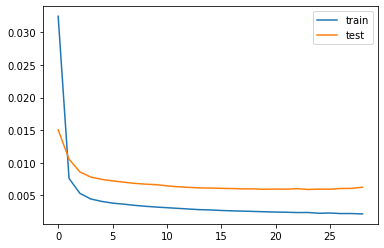

In [19]:

model = LSTM_model(train_X, train_Y, VALIDATION,  TIME,FEATURE)


In [20]:
trainPredict = model.predict(ori_X)
testPredict = model.predict(test_X)

mse_train,mse_test, nse_train, nse_test = eva_error(trainPredict,ori_Y,testPredict,test_y)
print(".......mse (trian,test) || nse (trian,test).......")
print(mse_train,mse_test, "||",nse_train, nse_test )
print("="*20,"With inverse scalar","="*20)

scale_trainPredict = scaler_target.inverse_transform(trainPredict)
scale_testPredict = scaler_target.inverse_transform(testPredict)
mse_train,mse_test, nse_train, nse_test = eva_error(scale_trainPredict,ori_Y,scale_testPredict,test_y)
print(mse_train,mse_test,  "||",nse_train, nse_test)

.......mse (trian,test) || nse (trian,test).......
0.0036179798 0.012805741 || [0.65908075] [-0.16819382]
==================== With inverse scalar ====================
0.014434119 0.049071725 || [-0.36011519] [-3.47653003]


# Trial CNN

In [6]:
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

In [12]:
def model_cnn(train_X, train_Y, validation):
    epochs = 100
    batch = 256
    lr = 0.0003
    adam = optimizers.Adam(lr)
    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(50, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mse', optimizer=adam)
    model_cnn.summary()
    
    # callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=2)
    # callbacks = [callback_early_stopping]
    callbacks = None
    history = model_cnn.fit(train_X, train_Y, epochs=epochs, batch_size=batch, verbose=1,shuffle=False,validation_data=validation,callbacks=callbacks)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model_cnn

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6, 64)             4544      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                9650      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 14,245
Trainable params: 14,245
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 159ms/step - loss: 0.6346 - val_loss: 0.6279
Epoch 2/100
1/1 [

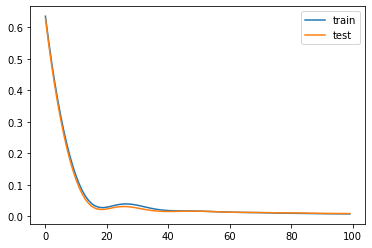

In [13]:
model_cnn1d = model_cnn(train_X, train_Y, VALIDATION)

In [14]:
trainPredict = model_cnn1d.predict(ori_X)
testPredict = model_cnn1d.predict(test_X)

print(trainPredict.shape,ori_Y.shape,testPredict.shape,test_y.shape)

mse_train,mse_test, nse_train, nse_test = eva_error(trainPredict,ori_Y,testPredict,test_y)
print(".......mse (trian,test) || nse (trian,test).......")
print(mse_train,mse_test, "||",nse_train, nse_test )
print("="*20,"With inverse scalar","="*20)

scale_trainPredict = scaler_target.inverse_transform(trainPredict)
scale_testPredict = scaler_target.inverse_transform(testPredict)
mse_train,mse_test, nse_train, nse_test = eva_error(scale_trainPredict,ori_Y,scale_testPredict,test_y)
print(mse_train,mse_test,  "||",nse_train, nse_test)

(279, 1) (279, 1) (120, 1) (120, 1)
.......mse (trian,test) || nse (trian,test).......
0.00838682 0.05075221 || [0.20971694] [-3.62983088]
==================== With inverse scalar ====================
0.035195313 0.20034553 || [-2.31642533] [-17.27636615]


# LSTM seq2seq

In [21]:
# multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


In [24]:
# define dataset
X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([[40,50,60],[50,60,70],[60,70,80],[70,80,90]])


In [25]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

In [30]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(3, 1)))
model.add(RepeatVector(y.shape[1]))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               40800     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 3, 100)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 3, 100)            80400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [31]:
# fit model
model.fit(X, y, epochs=100, verbose=0)
# demonstrate prediction
x_input = array([50, 60, 70])
x_input = x_input.reshape((1, 3, 1))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[ 79.3126 ]
  [ 90.22875]
  [102.40336]]]


# Trial Pyearth

In [10]:
from pyearth import Earth

In [11]:
#r='data/instant_data/rain_small.csv'
#w='data/instant_data/water_small.csv'
r = "data/instant_data/rain.csv"
w = 'data/instant_data/water.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean()


X_in = df['2013-01-01':'2015-01-01'].interpolate(limit=15)
X_in = X_in.astype('float32')

DataFrame shape: (833425, 1245)


In [12]:
X = X_in.drop([TARGET],axis=1)
xlabels = list(X.columns)
X = X.fillna(0).values
y = np.log(X_in[TARGET].fillna(0).values)

where_are_NaNs = np.isnan(y)
y[where_are_NaNs] = 0

print(X.shape)
print(y.shape)

(731, 1244)
(731,)


In [13]:
#Fit an Earth model
criteria = ('rss', 'gcv', 'nb_subsets')
model = Earth(enable_pruning = True,
            #   max_degree=3,
            #   max_terms=10,
              minspan_alpha=.5,
              feature_importance_type=criteria,
              verbose=True)


model.fit(X,y,xlabels=xlabels)


Beginning forward pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.296832  1      0.298  0.000  0.000  
1     0       935  364   0.144594  3      0.147  0.513  0.506  
2     0       1016  544   0.118268  5      0.122  0.602  0.590  
3     0       1015  516   0.110742  7      0.116  0.627  0.611  
4     0       873  591   0.104027  9      0.110  0.650  0.630  
5     0       715  554   0.097734  11     0.105  0.671  0.647  
6     0       882  501   0.093214  13     0.102  0.686  0.658  
7     0       934  -1    0.089119  14     0.098  0.700  0.671  
8     0       998  296   0.084469  16     0.094  0.715  0.684  
9     0       428  558   0.082088  18     0.093  0.723  0.688  
10    0       879  437   0.079751  20     0.091  0.731  0.693  
11    0       935  514   0.077447  22     0.090  0.739  0.697  
12    0       9

Earth(feature_importance_type=('rss', 'gcv', 'nb_subsets'), minspan_alpha=0.5,
      verbose=True)

In [14]:
#Print the model
print(model.trace())
print(model.summary())

Forward Pass
----------------------------------------------------------------
iter  parent  var   knot  mse       terms  gcv    rsq    grsq   
----------------------------------------------------------------
0     -       -     -     0.296832  1      0.298  0.000  0.000  
1     0       935   364   0.144594  3      0.147  0.513  0.506  
2     0       1016  544   0.118268  5      0.122  0.602  0.590  
3     0       1015  516   0.110742  7      0.116  0.627  0.611  
4     0       873   591   0.104027  9      0.110  0.650  0.630  
5     0       715   554   0.097734  11     0.105  0.671  0.647  
6     0       882   501   0.093214  13     0.102  0.686  0.658  
7     0       934   -1    0.089119  14     0.098  0.700  0.671  
8     0       998   296   0.084469  16     0.094  0.715  0.684  
9     0       428   558   0.082088  18     0.093  0.723  0.688  
10    0       879   437   0.079751  20     0.091  0.731  0.693  
11    0       935   514   0.077447  22     0.090  0.739  0.697  
12    0     

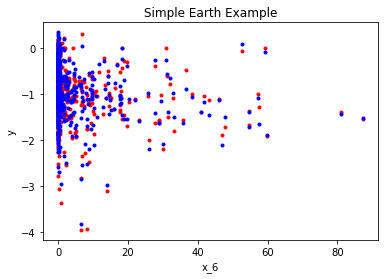

In [15]:
#Plot the model
y_hat = model.predict(X)
plt.figure()
plt.plot(X[:,6],y,'r.')
plt.plot(X[:,6],y_hat,'b.')
plt.xlabel('x_6')
plt.ylabel('y')
plt.title('Simple Earth Example')
plt.show()


In [16]:
print(model.summary_feature_importances(sort_by='gcv')[:2000])

             rss    gcv    nb_subsets
BKK006_w     0.53   0.63   0.01          
BKK007_w     0.12   0.13   0.05          
DNP024_w     0.03   0.03   0.02          
GLF002_w     0.03   0.02   0.02          
TB0003_r     0.02   0.02   0.02          
WEI061_r     0.02   0.02   0.02          
WEI131_r     0.01   0.01   0.02          
TB0002_w     0.01   0.01   0.02          
NKO002_w     0.01   0.01   0.02          
CPY009_w     0.01   0.01   0.02          
DIV003_r     0.01   0.01   0.02          
SACS_r       0.01   0.01   0.02          
PIN001_w     0.01   0.01   0.01          
BKK002_w     0.01   0.01   0.02          
WEI051_r     0.01   0.00   0.01          
DNP004_r     0.01   0.00   0.02          
CHI005_r     0.00   0.00   0.01          
PDAM_r       0.00   0.00   0.01          
PANC_r       0.00   0.00   0.01          
BLUG_r       0.00   0.00   0.02          
RCHM_r       0.01   0.00   0.02          
BSDE_r       0.00   0.00   0.02          
KWN001_r     0.01   0.00   0.02       

# Trial Pyearth_timerseries

In [17]:
LOOKBACK=7
TARGET= 'CPY015_w'
FEATURE = X_in.shape[1]

prep = preprocess(X_in,Y_column=TARGET,n_timelag=LOOKBACK,n_feature=FEATURE)
X,y = prep.ori_X,prep.ori_Y 

UnboundLocalError: local variable 'scaler' referenced before assignment

In [96]:
xlabels = list(X.columns)

where_are_NaNs = np.isnan(y)
y[where_are_NaNs] = 0

print(X.shape)
print(y.shape)

(399, 245)
(399,)


In [99]:
#Fit an Earth model
criteria = ('rss', 'gcv', 'nb_subsets')
model = Earth(enable_pruning = True,
            #   max_degree=3,
            #   max_terms=10,
              minspan_alpha=.5,
              feature_importance_type=criteria,
              verbose=True)

model.fit(X,y,xlabels=xlabels)


Beginning forward pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.039219  1      0.039  0.000  0.000  
1     0       235  284   0.020674  3      0.021  0.473  0.459  
2     0       163  20    0.018878  5      0.020  0.519  0.494  
3     0       201  75    0.017140  7      0.019  0.563  0.528  
4     0       235  394   0.015880  9      0.018  0.595  0.551  
5     0       28   201   0.014728  11     0.017  0.624  0.572  
6     0       166  76    0.014209  13     0.017  0.638  0.576  
7     0       172  327   0.013621  15     0.016  0.653  0.582  
8     0       161  288   0.013159  17     0.016  0.664  0.585  
9     0       13   -1    0.012788  18     0.016  0.674  0.591  
10    0       112  156   0.012425  20     0.016  0.683  0.592  
11    0       198  -1    0.012085  21     0.016  0.692  0.597  
12    0       97 

Earth(feature_importance_type=('rss', 'gcv', 'nb_subsets'), minspan_alpha=0.5,
      verbose=True)

In [100]:
print(model.summary_feature_importances(sort_by='gcv'))

                  rss    gcv    nb_subsets
CPY015_w(t-1)     0.61   0.79   0.06          
PIN001_r(t-7)     0.04   0.04   0.01          
KWN002_w(t-2)     0.04   0.03   0.03          
CPY009_w(t-2)     0.04   0.02   0.04          
PIN001_w(t-3)     0.02   0.01   0.03          
NAN009_w(t-5)     0.02   0.01   0.03          
KWN002_w(t-3)     0.02   0.01   0.03          
CPY004_w(t-1)     0.01   0.01   0.01          
NAN012_w(t-4)     0.02   0.01   0.03          
NAN009_w(t-2)     0.02   0.01   0.03          
NAN010_w(t-7)     0.02   0.01   0.04          
NAN013_w(t-6)     0.01   0.01   0.03          
CPY009_w(t-4)     0.01   0.01   0.01          
NAN009_w(t-7)     0.01   0.01   0.03          
CHM004_w(t-3)     0.01   0.01   0.03          
PIN001_w(t-1)     0.01   0.00   0.01          
NAN013_r(t-5)     0.00   0.00   0.00          
KWN002_r(t-5)     0.00   0.00   0.00          
NAN012_r(t-5)     0.00   0.00   0.00          
PIN001_r(t-5)     0.00   0.00   0.00          
NAN011_r(t-5)    

# save error dataframe

In [23]:
error_scores = list()
mae_scores = list()
    
error_scores_train = list()
mae_scores_train = list()

col = ['model','MSE','NSE',"n_feature","n_timelag"]
Rec = pd.DataFrame(columns =col)

In [26]:
Rec

,model,MSE,NSE,n_feature,n_timelag


,model,MSE,NSE,n_feature,n_timelag
